In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
training_labels = pd.read_csv("../input/g2net-gravitational-wave-detection/training_labels.csv")
training_labels.head()

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1


In [5]:
import os
import json
import random
import collections

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def convert_id_to_path(image_id: str, is_train: bool=True) -> str:
    folder = "train" if is_train else "test"
    return "../input/g2net-gravitational-wave-detection/{}/{}/{}/{}/{}.npy".format(
        folder, image_id[0], image_id[1], image_id[2], image_id 
    )

In [7]:
train_df = pd.read_csv("../input/g2net-gravitational-wave-detection/training_labels.csv")
train_df

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1
...,...,...
559995,ffff9a5645,1
559996,ffffab0c27,0
559997,ffffcf161a,1
559998,ffffd2c403,0


<AxesSubplot:xlabel='target', ylabel='count'>

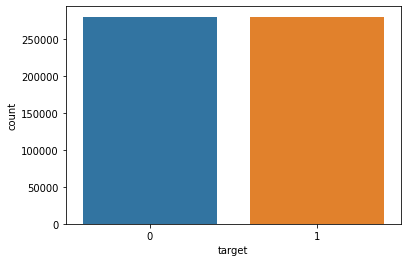

In [8]:
sns.countplot(data=train_df, x="target")

In [9]:
def visualize_samples(_id, 
                      target, 
                      colors=['red', 'black', 'green'], 
                      signal_source=["LIGO Hanford", "LIGO Livingston", "Virgo"]
                     ):
    
    path = convert_id_to_path(_id)
    x = np.load(path)
    plt.figure(figsize=(16, 7))
    for i in range(3):
        plt.subplot(4, 1, i+1)
        plt.plot(x[i], color=colors[i])
        plt.legend(signal_source[i], fontsize=12, loc="lower right")
        
        plt.subplot(4, 1, 4)
        plt.plot(x[i], color=colors[i])
        
    plt.subplot(4, 1, 4)
    plt.legend(signal_source, fontsize=12, loc="lower right")

    plt.suptitle(f"id: {_id} target: {target}", fontsize=16)
    plt.show()    

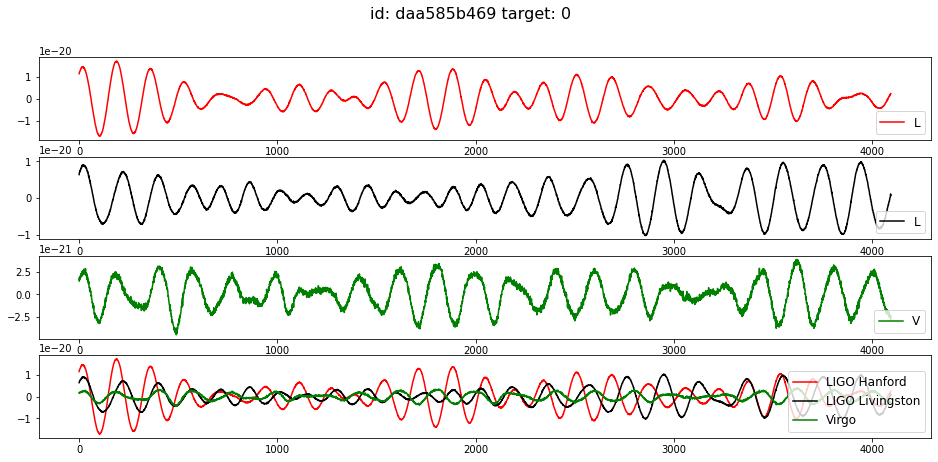

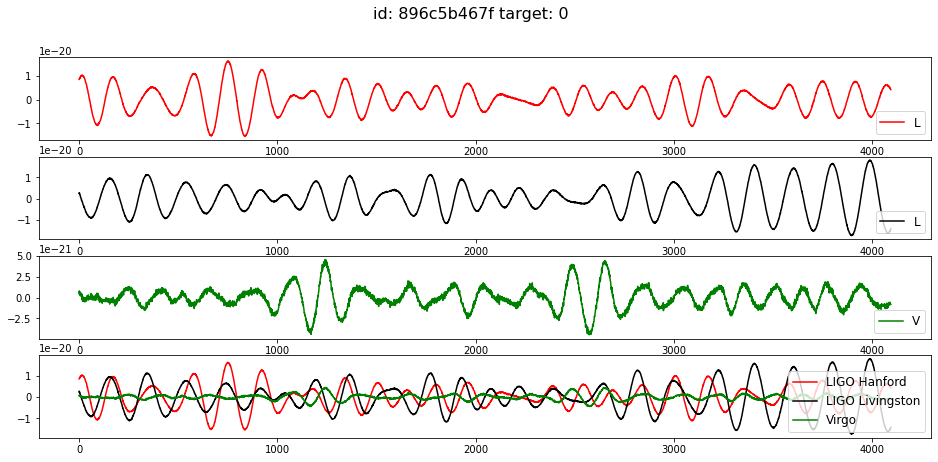

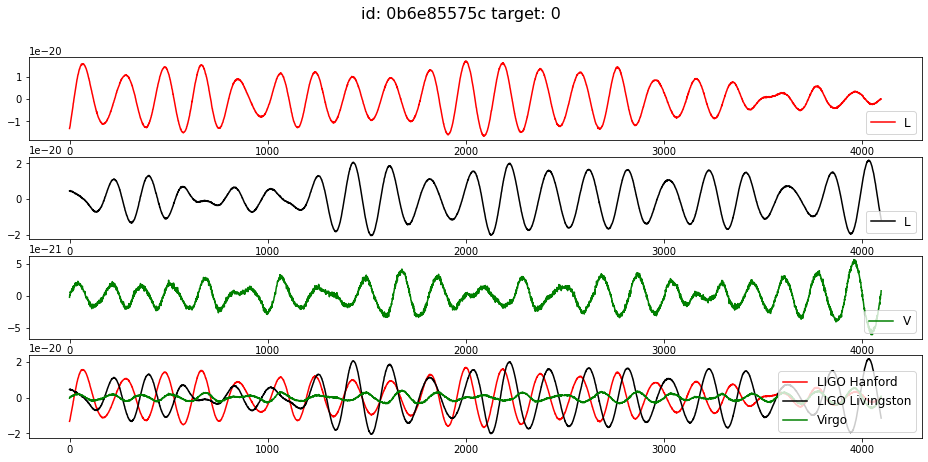

In [10]:
for i in random.sample(train_df.index.tolist(), 3):
    _id = train_df.iloc[i]["id"]
    target = train_df.iloc[i]["target"]

    visualize_samples(_id, target)

In [11]:
import librosa
import librosa.display

In [12]:
def visualize_spectrograms(_id, target, signal_source=["LIGO Hanford", "LIGO Livingston", "Virgo"]):
    
    path = convert_id_to_path(_id)
    x = np.load(path)
    
    plt.figure(figsize=(16, 5))
    for i in range(3):
        X = librosa.stft(x[i]/ x[i].max())
        Xdb = librosa.amplitude_to_db(abs(X))
        plt.subplot(1, 3, i+1)
        librosa.display.specshow(Xdb, sr=2048, x_axis="time", y_axis="hz", vmin=30, vmax=50)
        
        plt.colorbar()
        plt.title(signal_source[i], fontsize=14)
    
    plt.suptitle(f"id: {_id} target: {target}", fontsize=16)
    plt.show()

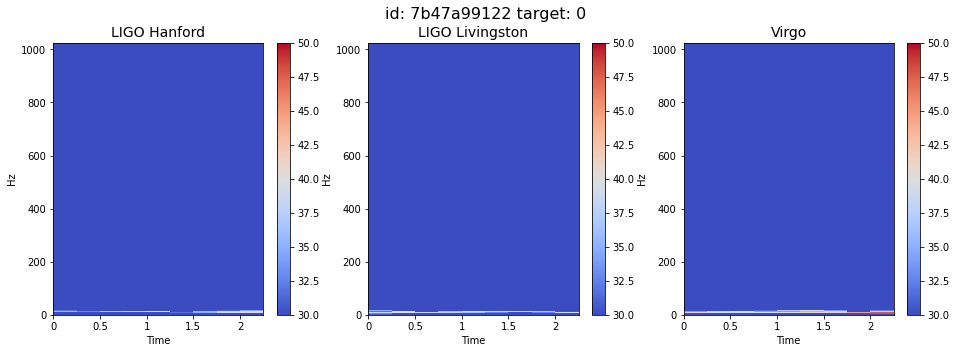

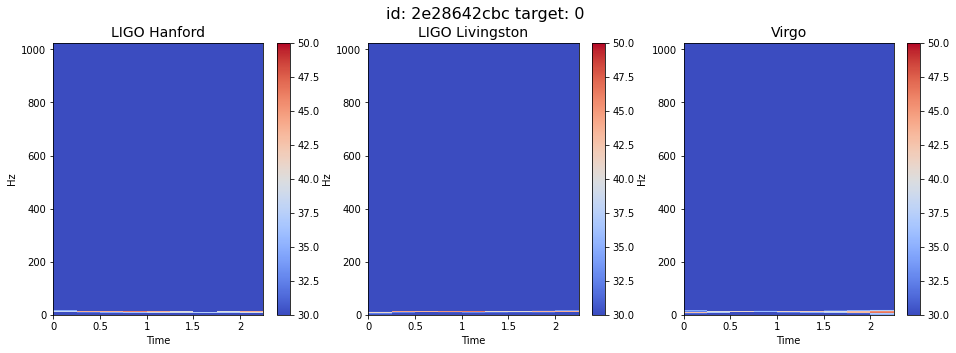

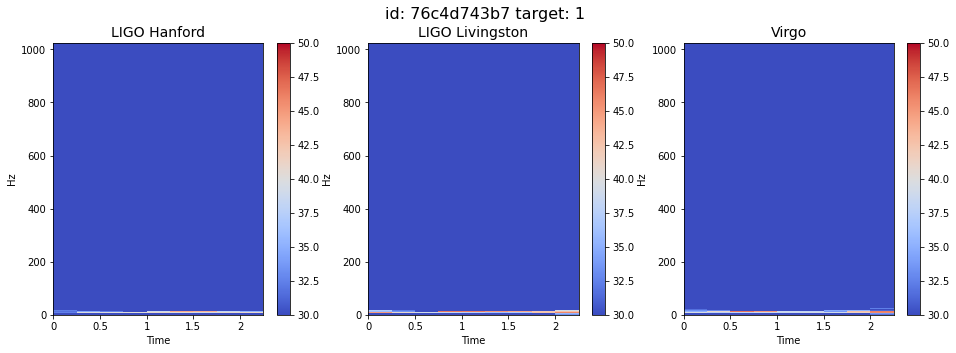

In [13]:
for i in random.sample(train_df.index.tolist(), 3):
    _id = train_df.iloc[i]["id"]
    target = train_df.iloc[i]["target"]

    visualize_spectrograms(_id, target)

In [14]:
def visualize_sample_mfcc(
    _id, 
    target,
    signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo"),
    sr=2048,
):
    x = np.load(convert_id_to_path(_id))
    plt.figure(figsize=(16, 5))
    for i in range(3):
        mfccs = librosa.feature.mfcc(x[i] / x[i].max(), sr=sr)
        plt.subplot(1, 3, i + 1)
        librosa.display.specshow(mfccs, sr=sr, x_axis="time", vmin=-200, vmax=50, cmap="coolwarm")
        plt.title(signal_names[i], fontsize=14)
        plt.colorbar()

    plt.suptitle(f"id: {_id} target: {target}", fontsize=16)
    plt.show()

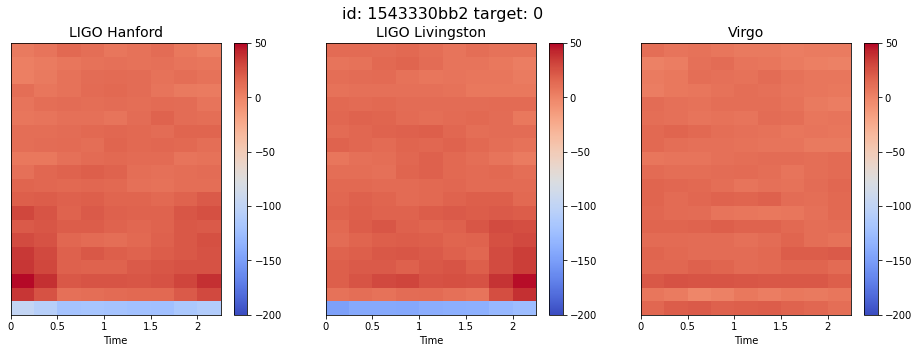

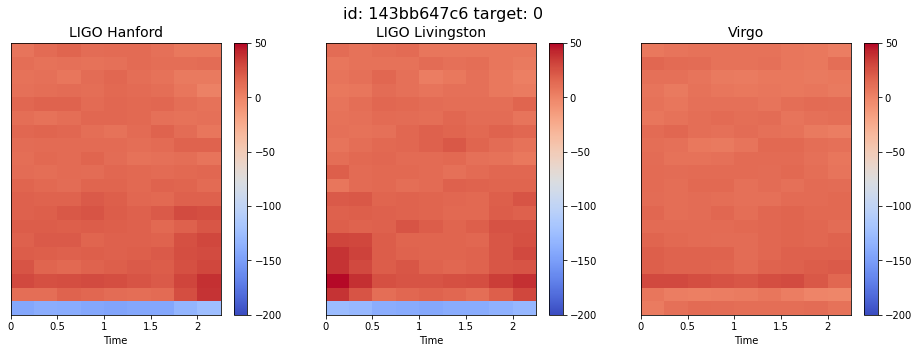

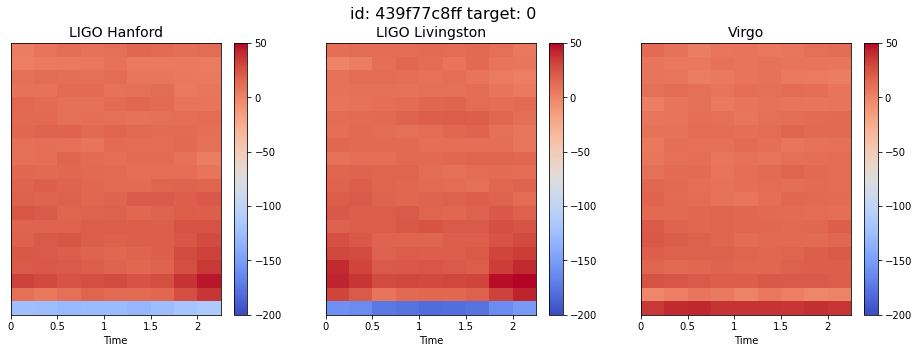

In [15]:
for i in random.sample(train_df.index.tolist(), 3):
    _id = train_df.iloc[i]["id"]
    target = train_df.iloc[i]["target"]

    visualize_sample_mfcc(_id, target)

In [16]:
!pip install -q nnAudio -qq

In [17]:
from nnAudio.Spectrogram import CQT1992v2

In [18]:
def apply_qtransform(signal, transform=CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64)):
    
    waves = np.hstack(signal)
    waves = waves/np.max(waves)
    waves = torch.from_numpy(waves).float()
    image = transform(waves)
    return image

CQT kernels created, time used = 0.0380 seconds


/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


In [19]:
import torch
import numpy as np
import pandas as pd

In [20]:
def get_train_file_path(image_id):
    return "../input/g2net-gravitational-wave-detection/train/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

In [21]:
train = train_df.copy()

In [22]:
train["file_path"] = train["id"].apply(get_train_file_path)

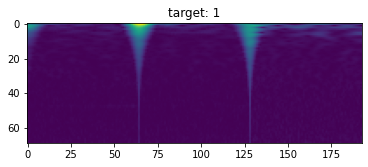

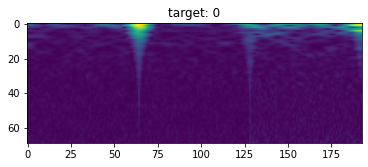

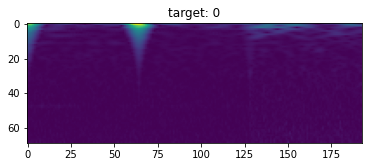

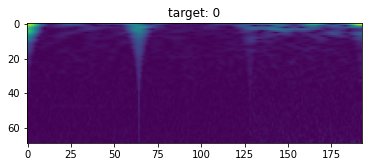

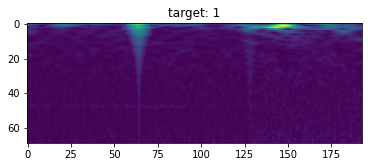

In [23]:
for i in range(5):
    waves = np.load(train.loc[i, 'file_path'])
    image = apply_qtransform(waves)
    target = train_df.loc[i, 'target']
    plt.imshow(image[0])
    plt.title(f"target: {target}")
    plt.show()

In [24]:
class CFG:
    apex=False
    debug=False
    print_freq=100
    num_workers=4
     
    model_name='tf_efficientnet_b7_ns'
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=3
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=3 # CosineAnnealingLR
    #T_0=3 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=16
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    qtransform_params={"sr": 2048, "fmin": 20, "fmax": 1024, "hop_length": 32, "bins_per_octave": 8}
    seed=42
    target_size=1
    target_col='target'
    n_fold=5
    trn_fold=[0] # [0, 1, 2, 3, 4]
    train=True
    grad_cam=True
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=10000, random_state=CFG.seed).reset_index(drop=True)

In [25]:
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
import wandb

In [27]:
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [28]:
class TrainDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.df = df
        self.filename = df["file_path"].values
        self.labels = df[CFG.target_col].values
        self.wave_transforms = CQT1992v2(**CFG.qtransform_params)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_path = self.filename[idx]
        waves = np.load(file_path)
        image = self.apply_qtransforms(waves, self.wave_transforms)
        image = image.squeeze().numpy()
        if self.transform:
            image = self.transform(image=image)["image"]
        label = torch.tensor(self.labels[idx]).float()
        return image, label
    
    def apply_qtransforms(self, signal, transform):
        waves = np.hstack(signal)
        waves = waves/np.max(waves)
        waves = torch.from_numpy(waves).float()
        image = transform(waves)
        return image

In [29]:
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            ToTensorV2(),
        ])

In [30]:
class Model_proto(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained, in_chans=1)
        
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(self.n_features, self.cfg.target_size)
    
    def forward(self, x):
        output = self.model(x)
        return output

In [31]:
def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

run = wandb.init(
    project="G2NET-Experiments",
    name="exp1",
    config=class2dict(CFG),
    group=CFG.model_name,
    job_type="train_model"
)

wandb: Currently logged in as: visith (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [32]:
!pip install wandb --upgrade

     |████████████████████████████████| 1.6 MB 4.2 MB/s eta 0:00:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.10.33
    Uninstalling wandb-0.10.33:
      Successfully uninstalled wandb-0.10.33
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.5.0 requires wandb<0.11.0,>=0.10.0, but you have wandb 0.12.0 which is incompatible.


In [33]:
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [34]:
def get_score(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

In [35]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [36]:
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train[CFG.target_col])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby(['fold', 'target']).size())

fold  target
0     0         56014
      1         55986
1     0         56014
      1         55986
2     0         56014
      1         55986
3     0         56014
      1         55986
4     0         56014
      1         55986
dtype: int64

In [37]:
train.head()

,id,target,file_path,fold
0,00000e74ad,1,../input/g2net-gravitational-wave-detection/tr...,2
1,00001f4945,0,../input/g2net-gravitational-wave-detection/tr...,1
2,0000661522,0,../input/g2net-gravitational-wave-detection/tr...,3
3,00007a006a,0,../input/g2net-gravitational-wave-detection/tr...,3
4,0000a38978,1,../input/g2net-gravitational-wave-detection/tr...,4


CQT kernels created, time used = 0.0148 seconds


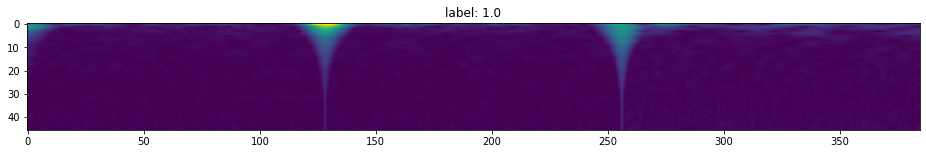

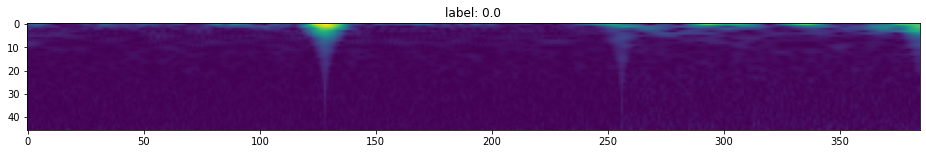

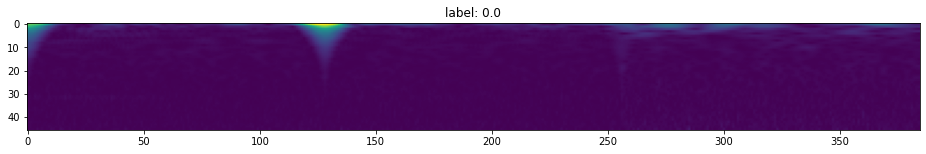

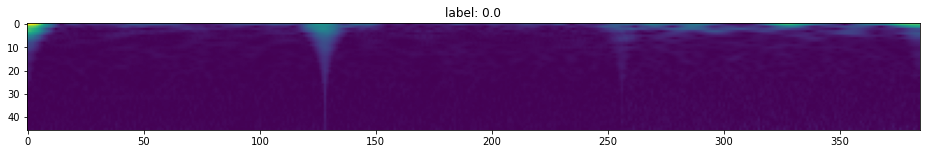

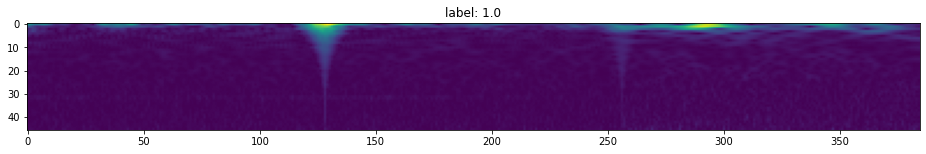

In [38]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(5):
    plt.figure(figsize=(16,12))
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

In [39]:
!pip install timm

     |████████████████████████████████| 376 kB 4.4 MB/s eta 0:00:01


In [40]:
import timm

In [41]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.sum = 0
        self.avg = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val*n
        self.count += n
        self.avg = self.sum / self.count

In [42]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [43]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    date_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    
    model.train()
    start = end = time.time()
    global_step = 0
    for step , (images, labels) in enumerate(train_loader):
        date_time.update(time.time() - end)
        images, labels = images.to(device), labels.to(device)
        
        batch_size = labels.size(0)
        if CFG.apex:
            with autocast():
                y_preds = model(images)
                loss = criterion(y_preds.view(-1), labels)
        else:
            y_preds = model(images)
            loss = criterion(y_preds.view(-1), labels)
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        wandb.log({f"[fold{fold}] loss": losses.val,
                   f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg

In [44]:
def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds.view(-1), labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions    

In [45]:
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='train'))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = Model_proto(CFG, pretrained=True)
    model.to(device)
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss()

    best_score = 0.
    best_loss = np.inf
    
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = Model_proto(CFG, pretrained=True)
    model.to(device)
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time
    LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
    wandb.log({f"[fold{fold}] epoch": epoch+1, 
                   f"[fold{fold}] avg_train_loss": avg_loss, 
                   f"[fold{fold}] avg_val_loss": avg_val_loss,
                   f"[fold{fold}] score": score})

    if score > best_score:
        best_score = score
        LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
        
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth')
    
    valid_folds['preds'] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth', 
                                      map_location=torch.device('cpu'))['preds']

    return valid_folds

In [46]:
def main():

    """
    Prepare: 1.train 
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
        
    wandb.finish()    

In [47]:
#import torch
#torch.cuda.empty_cache()

In [ ]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========


CQT kernels created, time used = 0.0136 seconds
CQT kernels created, time used = 0.0081 seconds


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b7_ns-1dbc32de.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b7_ns-1dbc32de.pth


Epoch: [1][0/28000] Elapsed 0m 2s (remain 1129m 35s) Loss: 0.7414(0.7414) Grad: 5.7646  LR: 0.000100  
Epoch: [1][100/28000] Elapsed 1m 6s (remain 308m 1s) Loss: 0.5188(0.6599) Grad: 5.1217  LR: 0.000100  
Epoch: [1][200/28000] Elapsed 2m 10s (remain 301m 2s) Loss: 0.5160(0.6166) Grad: 4.5098  LR: 0.000100  
Epoch: [1][300/28000] Elapsed 3m 14s (remain 297m 58s) Loss: 1.1461(0.5987) Grad: 5.2912  LR: 0.000100  
Epoch: [1][400/28000] Elapsed 4m 17s (remain 295m 54s) Loss: 0.4494(0.5828) Grad: 1.7871  LR: 0.000100  
Epoch: [1][500/28000] Elapsed 5m 21s (remain 293m 55s) Loss: 0.4135(0.5739) Grad: 1.3565  LR: 0.000100  
Epoch: [1][600/28000] Elapsed 6m 25s (remain 292m 32s) Loss: 0.3646(0.5663) Grad: 1.7336  LR: 0.000100  
Epoch: [1][700/28000] Elapsed 7m 28s (remain 291m 7s) Loss: 0.4745(0.5614) Grad: 1.9547  LR: 0.000100  
Epoch: [1][800/28000] Elapsed 8m 32s (remain 289m 47s) Loss: 0.4518(0.5559) Grad: 1.7865  LR: 0.000100  
Epoch: [1][900/28000] Elapsed 9m 35s (remain 288m 24s) Loss: 

In [ ]:
def save_model(self, n_epoch, save_path):
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_valid_score": model.best_valid_score,
                "n_epoch": n_epoch,
            },
            save_path,
        )